# Traveling Sales Person Project

Embarking on the Traveling Salesman Problem (TSP) feels like diving headfirst into the world of algorithmic puzzles and computational wizardry. Picture this: you're a delivery driver with a bunch of packages on your truck, and the challenge is to figure out the most efficient route that delivers each package and brings you back to the distribution center. Sounds simple, right? Well, here's the twist: it gets crazily complex as the number of stops goes up. But hey, that's where the fun begins! So, buckle up – we're about to navigate the academic maze of TSP!

In this specific problem, I am not just optimizing the route for one truck, but determing routes for 10 trucks with a total of 500 packages.








In [1]:
#!pip install gurobipy

In [2]:
import numpy as np
import gurobipy as gp
import pandas as pd
import math as math
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestCentroid

### Part 1

In part 1, we solve the problem such that the total distance travelled using
all 10 trucks is minimized. It is first done using clustering to assign packages to trucks, and then with the 3-change simulated annealing methodology.

In [3]:
data = pd.read_csv('locations1.csv')
data.head()

,x,y
0,0.321665,-0.277641
1,0.838688,-0.565661
2,0.778286,0.130336
3,0.755618,0.065864
4,1.298365,0.255950


### Clustering

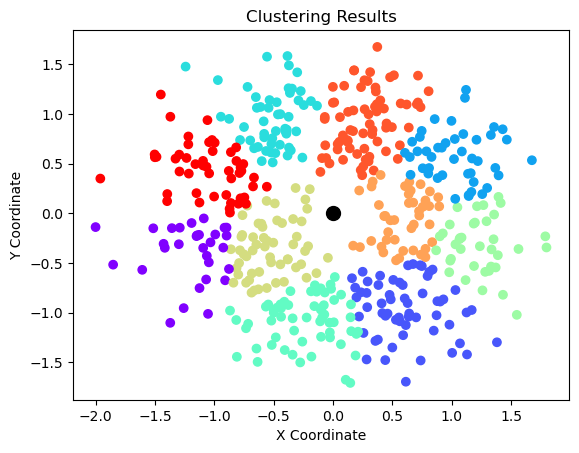

In [4]:
X = data[['x', 'y']]

num_clusters = 10 # num clusters = num trucks

# create and fit a K-Means model
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X)
data['cluster_label'] = kmeans.labels_
plt.scatter(data['x'], data['y'], c=data['cluster_label'], cmap='rainbow')
plt.title('Clustering Results')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.scatter(0, 0, c='black', marker='o', s=100)  # Adjust the size (s) as needed
plt.show()

In [5]:
# perform TSP for each truck

total_distance = 0
optimal_routes = []


for cluster in range(num_clusters):
    cluster_data = data[data['cluster_label'] == cluster]
    origin = pd.DataFrame({'x': [0], 'y': [0], 'cluster_label': [cluster] }) # add (0,0) distribution center to each cluster
    cluster_data = pd.concat([origin, cluster_data], ignore_index=True) # reverse order of concatenation to make (0,0) the first row

    cluster_coordinates = cluster_data[['x', 'y']].values
    num_points = len(cluster_coordinates)
    distMat = np.zeros((num_points, num_points)) # empty distance matrix

    # calculate the distance between each pair of points in the cluster
    for i in range(num_points):
        for j in range(i, num_points):
            distance = np.linalg.norm(cluster_coordinates[i] - cluster_coordinates[j])
            distMat[i, j] = distance
            distMat[j, i] = distance

    for i in range(num_points):
        for j in range(num_points):
             if distMat[i, j] == 0:
                distMat[i, j] = 1000

    print(f'TSP for truck {cluster+1}')

    # integer program

    N = len(distMat)
    mod = gp.Model()
    x = mod.addMVar((N,N),vtype='B') # NxN
    u = mod.addMVar(N)
    mod.setObjective(gp.quicksum(x[i,j]*distMat[i,j] for i in range(N) for j in range(N)))

    # constraints

    # enter each city once
    enter = mod.addConstrs((gp.quicksum(x[i,j] for i in range(N))==1) for j in range(N))
    # leave each city once
    leave = mod.addConstrs((gp.quicksum(x[i,j] for j in range(N))==1) for i in range(N))
    # u constraints:
    ucons = mod.addConstrs((u[i] - u[j] + N*x[i,j] <= (N-1)) for i in range(1,N) for j in range(1,N) if i != j)

    mod.Params.OutputFlag = 0
    mod.optimize()

    optimal_route = []
    curr_city = 0
    for _ in range(N - 1):
        for city in range(1, N):
            if x[curr_city, city].X > 0.5:
                optimal_route.append(city)
                curr_city = city
                break

    # Add the first city (origin) to complete the loop
    optimal_route.append(0)

    optimal_routes.append(optimal_route)


    total_distance += mod.objVal
    print(mod.objVal)
    print('')

print(f'Total Distance: {total_distance}')

TSP for truck 1
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-27
6.552392410062883

TSP for truck 2
7.965445955405524

TSP for truck 3
6.652098572135187

TSP for truck 4
6.848743270958337

TSP for truck 5
7.463528638668552

TSP for truck 6
6.5436297346966805

TSP for truck 7
5.621724806700655

TSP for truck 8
4.416588055230415

TSP for truck 9
7.245700752503001

TSP for truck 10
7.200634073648458

Total Distance: 66.51048627000968


In [6]:
total_distance

66.51048627000968

In [7]:
#@title Function to Plot All Routes
# data is the original data frame with the coordinates x & y, with/without cluster labels
# paths is the list of numpy arrays of paths, each for one truck/route
# title is the title of the graph
def draw_routes(data, paths, title = ""):
  plt.figure()
  if 'cluster_label' in data.columns: # if cluster is included, color points based on cluster
    plt.scatter(data['x'], data['y'], c=[cluster for cluster in data['cluster_label']])
  else:
    plt.scatter(data['x'], data['y'])

  for path in paths:
    # connect the points
    for i in range(len(path) - 1):
      curr_point = path[i]
      next_point = path[i+1]
      plt.plot([data.loc[curr_point]['x'], data.loc[next_point]['x']], [data.loc[curr_point]['y'], data.loc[next_point]['y']], 'r-')

    # connect the first and last points to close the path
    first_point = path[0]
    last_point = path[-1]
    plt.plot([data.loc[last_point]['x'], data.loc[first_point]['x']], [data.loc[last_point]['y'], data.loc[first_point]['y']], 'r-')


  plt.xlabel('X Coordinate')
  plt.ylabel('Y Coordinate')
  plt.title(title)
  plt.show()

In [8]:
#@title Re-import data to perform simulated annealing
xy = pd.read_csv('locations1.csv')

# Adds distribution center to dataframe
origin = pd.DataFrame({'x':0, 'y':0},index =[0])
xy = pd.concat([origin, xy]).reset_index(drop = True)

nx = xy.shape[0]
dist = np.zeros((nx,nx))
for i in range(nx):
    for j in range(nx):
        if i == j:
            dist[i,j] = 10000
        else:
            dist[i,j] = np.sqrt((xy['x'][i]-xy['x'][j])**2 + (xy['y'][i]-xy['y'][j])**2)

dist.shape

(501, 501)

### Annealing Functions

In [9]:
#@title  Reverse method
def reversal(trucks):
    random_ix = np.random.randint(0, len(trucks)) # chooses random truck
    path = trucks[random_ix] # retreives path of truck
    nx = len(path)
    startstop = np.random.choice(nx,2,replace=False) # chooses random start and stop
    if startstop[0] > startstop[1]: # if start is greater than stop, does this
        subpath = np.append(path[startstop[0]:],path[:startstop[1]+1]) # Start + anything after, anything before stop + stop
        subpath = np.flip(subpath) # Flips the path
        newpath = np.append(path[startstop[1]+1:startstop[0]],subpath) # Everything between start and stop appended by reversed path
    else: # stop is greater than start
        subpath = path[startstop[0]:startstop[1]+1] # Everything between stop and start
        subpath = np.flip(subpath)
        newpath = np.append(path[:startstop[0]],subpath) # Everything before start put before subpath
        newpath = np.append(newpath,path[startstop[1]+1:]) # Everything after start put after subpath

    return [random_ix,newpath] # returns truck number and it's new path

In [10]:
# Transport method
def transport(trucks):
    random_ix = np.random.randint(0, len(trucks))
    path = trucks[random_ix]
    nx = len(path)
    startstop = np.random.choice(nx,2,replace=False)
    if startstop[0] > startstop[1]:
        remove_path = np.append(path[startstop[0]:],path[:(startstop[1]+1)])
        closed_path = path[(startstop[1]+1):startstop[0]]
    else:
        remove_path = path[startstop[0]:(startstop[1]+1)]
        closed_path = np.append(path[0:startstop[0]],path[(startstop[1]+1):])
    nc = len(closed_path)
    if nc > 0:
        paste = np.random.choice(nc,1)[0]
        newpath = np.append(closed_path[0:(paste+1)],remove_path)#,closed_path[(paste+1):])
        newpath = np.append(newpath,closed_path[(paste+1):])
    else:
        newpath = path
    return [random_ix,newpath]

In [11]:
# Change random package method
def package(t):
    random_steal = np.random.randint(0, len(trucks)) # random truck to steal from
    random_pack = 0
    while random_pack == 0: # loop to prevent the chosen package from being the distribution center (0,0)
      random_pack = np.random.randint(0, len(t[random_steal])) # Index of Package you're taking off truck
    random_give = np.random.randint(0, len(trucks)) # truck that receives it
    random_ix = np.random.randint(0, len(t[random_give])) # where in the route it's going
    package = t[random_steal][random_pack] # the package itself
    newpath = np.insert(t[random_give], random_ix, package) # puts package in the new truck's path
    return [random_give,newpath] # truck number + its new path

In [12]:
# Calculate Distance method
def measure_path(trucks,dist):
    total_dist = 0 # Total squared distance the package is going
    # Calculates distance each trucks path
    for path in trucks:
        nx = len(path)
        path_dist = 0
        for i in range(nx-1):
            path_dist += dist[path[i],path[i+1]]
        path_dist += dist[path[nx-1],path[0]]
        total_dist += path_dist**2
    return total_dist

### Cluster + 2-Change Annealing

In [13]:
trucks = [np.array([]) for i in range(10)]

for i in range(len(data)): # Go through entire data set
  cluster = data.iloc[i, 2] # Locate the cluster number it is (1-10)
  trucks[cluster] = np.append(trucks[cluster], [i]) # appends the package number in the correct truck

# adds distribution center to every truck route
for i in range(len(trucks)):
  trucks[i] = np.append([0], trucks[i])
  trucks[i] = trucks[i].astype(int)

# baseline truck route distance
best_distance = measure_path(trucks,dist)
print(f"""Starting distance: {best_distance**0.5}""")
# the original path from our truck arrays
best_path = np.copy(trucks)
coin = 0.95

for i in range(100000):
    test = np.copy(best_path) # path to change
    possible_methods = [transport(test), reversal(test)] # stores the two possible changes
    # 50/50 shot of choosing either
    method_choice = np.random.randint(0,2)
    method = possible_methods[method_choice]

    test[method[0]] = method[1]

    new_distance = measure_path(test,dist)

    if new_distance < best_distance:
        best_distance = new_distance
        best_path = test

    else:
        d = (new_distance**0.5) - (best_distance**0.5)
        prob = coin/(np.exp(d))
        if np.random.choice([0,1], p=[1-prob,prob]) == 1:
            best_path = test
            best_distance = new_distance

    coin *= 0.99

best_distance = best_distance**0.5
print(f"""Ending distance: {best_distance}""")
print(f"""Ideal paths: {best_path}""")




Starting distance: 10032.511795414299


/Users/rushilnakkana/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:804: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)
/var/folders/wz/klh9z5615l97x31_xnrcm8280000gn/T/ipykernel_10670/3792338347.py:36: RuntimeWarning: overflow encountered in exp
  prob = coin/(np.exp(d))


Ending distance: 40.37696083410947
Ideal paths: [array([331, 265,   0, 276, 316, 319, 313, 336, 346, 303, 325, 341, 332,
        320, 260, 278, 270, 280, 214, 297, 288, 274, 268, 263, 306, 262,
        305, 322, 293, 334, 259])
 array([492, 437, 459, 469, 495,   6, 491, 464, 433,  43, 482, 499, 449,
          0, 476,   1, 405, 465, 416, 413, 352, 428, 445, 440, 410, 354,
        419, 358, 364, 408, 389, 382, 367, 402, 423, 438, 431, 377, 442,
        412, 404, 414, 487, 390, 429, 430, 415, 424, 443, 477, 488, 472,
        486, 458, 468, 446, 478, 403, 447, 466])
 array([463,   0,  70,  62,  91,  97,  75, 135, 111,  52,  80,  58,  84,
         98,  77,  53,  79,  26,  85, 112,  82,  78,  66,  76,  92,  63,
        113,  27,  83,  71,  81,  95,  29,  18,  39,  11,  65,  72,  15,
          4,  50,  89,  25,  23, 479])
 array([224, 219, 245, 234, 203, 230, 211, 221, 231, 184, 173, 172, 151,
        185, 182, 222, 177, 212, 150, 146, 171, 179, 166, 192, 168, 181,
        141, 149, 198, 158,

[331 265   0 276 316 319 313 336 346 303 325 341 332 320 260 278 270 280
 214 297 288 274 268 263 306 262 305 322 293 334 259 331]



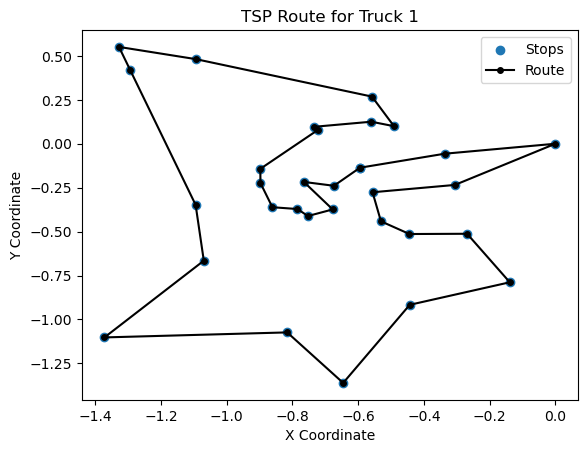

[492 437 459 469 495   6 491 464 433  43 482 499 449   0 476   1 405 465
 416 413 352 428 445 440 410 354 419 358 364 408 389 382 367 402 423 438
 431 377 442 412 404 414 487 390 429 430 415 424 443 477 488 472 486 458
 468 446 478 403 447 466 492]



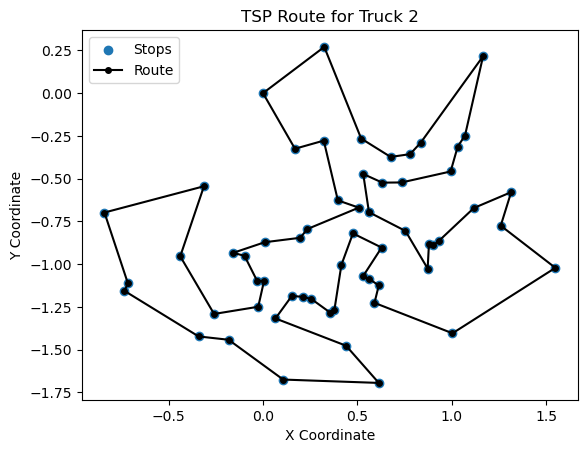

[463   0  70  62  91  97  75 135 111  52  80  58  84  98  77  53  79  26
  85 112  82  78  66  76  92  63 113  27  83  71  81  95  29  18  39  11
  65  72  15   4  50  89  25  23 479 463]



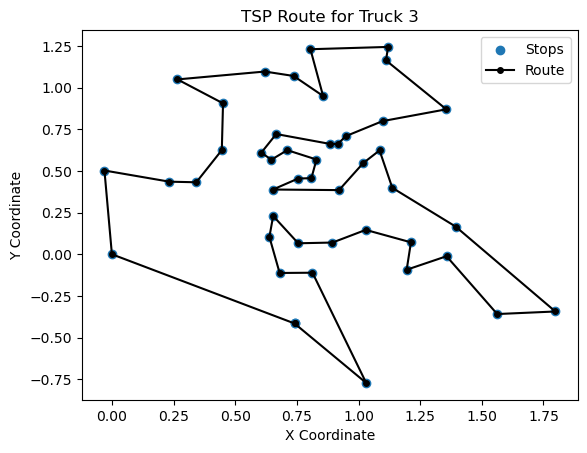

[224 219 245 234 203 230 211 221 231 184 173 172 151 185 182 222 177 212
 150 146 171 179 166 192 168 181 141 149 198 158 176 117 194 187 170 163
 160 145   0 253 201 208 237 190 161 225 183 152 199 178 246 174 243 224]



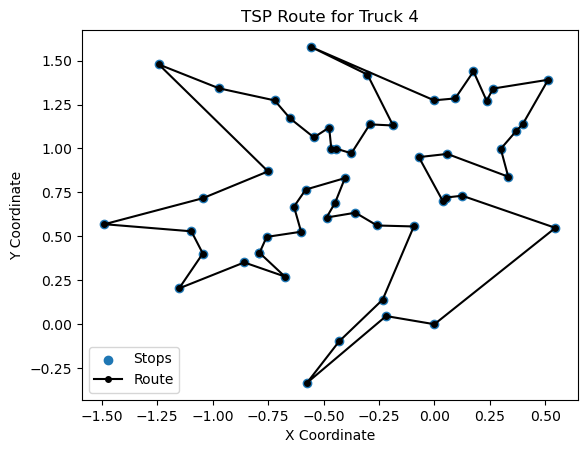

[439 391 359 417 411 420 406 441 353 427 392 360 351 371 386 418 381 399
 385 372 370 361 393 422 357 394 366 380 421 345 369 376 362 373 395 426
 375 338 344 435 308 302 350 324 388 356 349 384 314 379 398 340 329   0
 474 401 444 368 409 396 365 439]



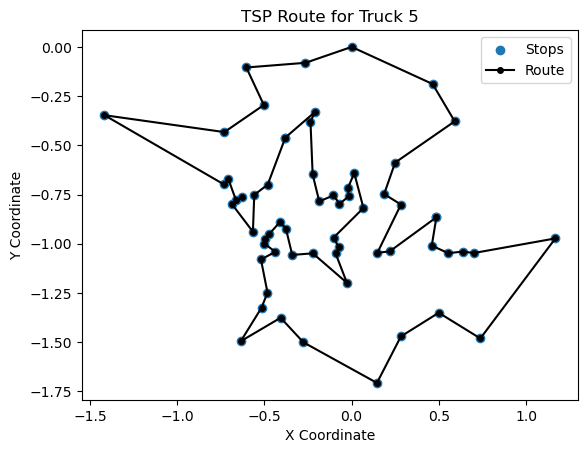

[  0  94  12  16   5  28  64  38  41  32 485  20   9 457  44 467 496  47
  21  35 494 497  10  33  46  45  17 451 471 490  34 450 470 460 493 483
 489 453   0]



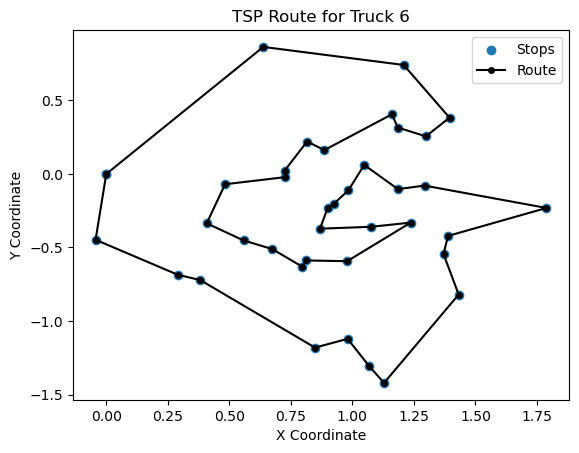

[342 333 335 323 256 311 312 261 337 347 289 321 264 326 307 317 287 267
 240 292 283 275 295 272 207 200 235 255 300 328 258 318 252 304 343 296
 348 236   0 434 452 425 378 383 355 407 363 397 387 301 315 310 290 309
 374 339 330 342]



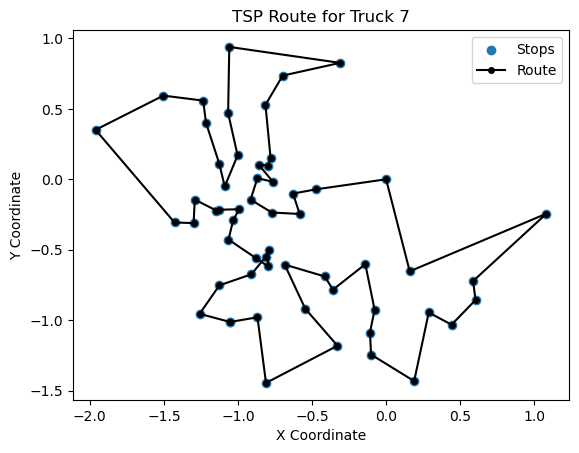

[ 19  30  13  36  24  54  40  86  60 133  68 123 124  88  56 147   0  31
  49  37   3  14   8 455 481 462   0 400 475 436 448 432 473   2   7 456
 454 461 484 498  22  48  42 480  19]



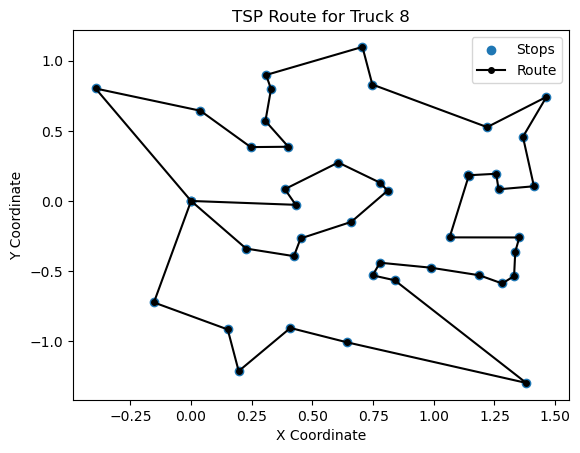

[105 197 102 108 119 132 121 189 131 100 191 154 215 157 196 180 193 159
 175 188 186 167 142 118 164 162 169 140 115 143 120 128 165 155 139 122
 110 144 103 126 107 101 127 106 130 137 109  74  67 114  96  59  90  73
  99  93 136  51  55  69  57 125  87 134 284   0  61 148 138 104 129 116
 105]



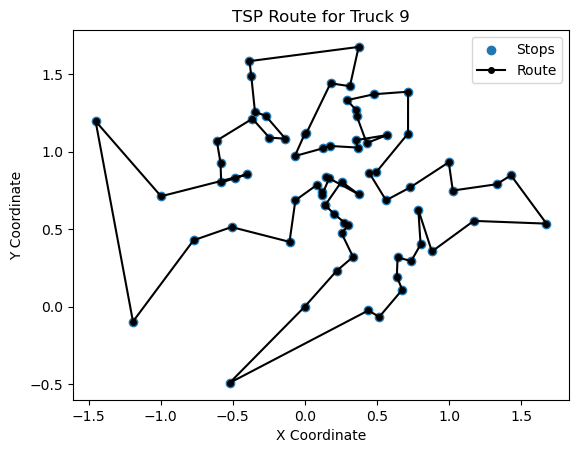

[233 218 227 299 291 327 273 294 298 277 279 266 269 281 271 205 282 229
 250 206 217 228 204 195 248 251 239 286 242 249 223 254 244 220 209 232
 213 202 153 226 247 238 216 156 285   0 241 257 210 233]



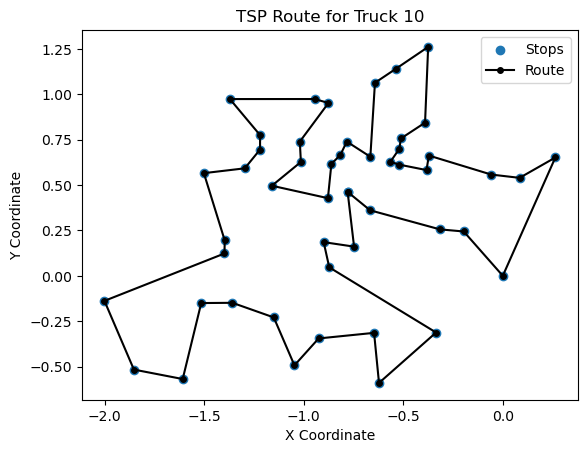

In [14]:
# plotting routes for cluster + 2-change annealing

num = 1
for path in best_path:
  path = np.append(path, path[0])
  print(path)
  print()
  x = []
  y = []
  for i in range(len(path)):
      row = path[i]
      stop = xy.iloc[row]
      x.append(stop[0])
      y.append(stop[1])

    # Scatter plot the points
  plt.scatter(x, y, cmap='rainbow', label='Stops')

    # Draw lines connecting the points in order
  plt.plot(x, y, linestyle='-', marker='o', markersize=4, c='k', label='Route')


  plt.title(f'TSP Route for Truck {num}')
  plt.xlabel('X Coordinate')
  plt.ylabel('Y Coordinate')
  plt.legend()
  plt.show()
  num += 1


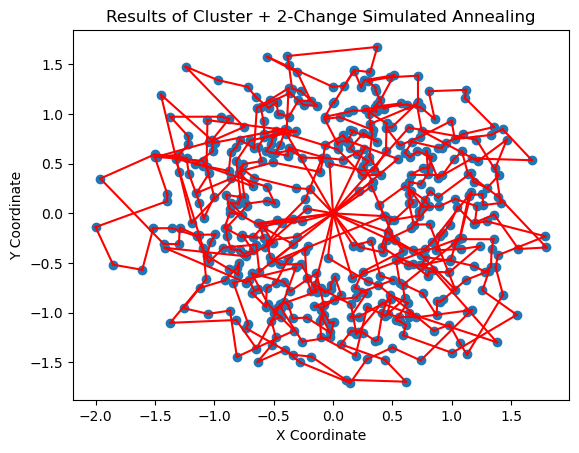

In [15]:
# Plot the routes for verification purposes
# 1) Is each route passing through the origin (0,0) / distribution center?
# 2) Is it a closed path?

draw_routes(xy, best_path, "Results of Cluster + 2-Change Simulated Annealing")

### 3-Change Annealing

In [16]:
r_locs = list(range(1, nx)) # List of all package locations, no distribution center (so no 0)

trucks = [np.array([]) for i in range(10)] # Create an empty array for all 10 trucks

# Takes each package and randomly assigns it
for i in range(len(r_locs)):
    random_index = np.random.randint(0, len(r_locs))
    random_value = r_locs[random_index] # Uses random index to choose 1 of 5 packages
    array_index = np.random.randint(0, 10) # Assigns to random truck
    trucks[array_index] = np.append(trucks[array_index], random_value) # Adds package to truck
    r_locs = np.delete(r_locs, random_index) # Deletes package from r_locs so don't have to worry about replacement

for i in range(len(trucks)):
    trucks[i] = np.append([0], trucks[i]) # adds distribution to each truck path
    trucks[i] = trucks[i].astype(int) # Changes to integer so can use for index



In [17]:
best_distance = measure_path(trucks,dist)
print(best_distance**0.5)
best_path = np.copy(trucks)
coin = 0.95

for i in range(100000):
    test = np.copy(best_path)
    possible_methods = [package(test), transport(test), reversal(test)]
    method_choice = np.random.randint(0,3)
    method = possible_methods[method_choice]

    test[method[0]] = method[1]

    new_distance = measure_path(test,dist)

    if new_distance < best_distance:
        best_distance = new_distance
        best_path = test

    else:
        d = (new_distance**0.5) - (best_distance**0.5)
        prob = coin/(np.exp(d))
        if np.random.choice([0,1], p=[1-prob,prob]) == 1:
            best_path = test
            best_distance = new_distance

    coin *= 0.99

best_distance = best_distance**0.5
print(best_distance)
print(best_path)



233.64679799666607


/var/folders/wz/klh9z5615l97x31_xnrcm8280000gn/T/ipykernel_10670/2815428553.py:22: RuntimeWarning: overflow encountered in exp
  prob = coin/(np.exp(d))


59.257692462280694
[array([392, 358, 310, 380, 416, 453, 288, 300, 214,   0,  91, 145,  51,
          4, 466, 417, 450, 500, 468, 458, 452, 480,  59,  80, 170, 135,
        139, 120, 167, 200, 188, 235, 217, 240, 292, 280, 227, 304, 306,
        331, 293, 312, 408, 323, 356, 330, 333, 342, 389, 382, 360, 367,
        423])
 array([128, 181, 137,  97,  62, 123, 163,  56,  70, 100, 241, 329, 208,
        361, 372, 339, 351, 441, 390, 411, 494, 486, 498,  22,   5,  28,
        464,  41,  27,  26,  63,  87, 455,   0, 291, 327, 379, 262, 318,
        286, 275, 337, 281, 205, 229, 211, 270, 159, 187])
 array([ 99,  12,  54,  24,  16,  93, 136, 129, 189, 160, 109, 176, 107,
        149, 143, 162, 179, 222, 231, 175, 212, 236,   0, 481, 301, 368,
        395, 315, 308, 284, 201, 334, 299, 215, 326, 264, 335, 333, 386,
        366, 377, 431, 477, 488, 403, 448, 378,   2, 454,  42, 497,  46,
         20, 125,  40])
 array([398, 245, 230, 206, 221, 207, 185, 118, 146, 194, 199, 238, 131,
        

[392 358 310 380 416 453 288 300 214   0  91 145  51   4 466 417 450 500
 468 458 452 480  59  80 170 135 139 120 167 200 188 235 217 240 292 280
 227 304 306 331 293 312 408 323 356 330 333 342 389 382 360 367 423 392]



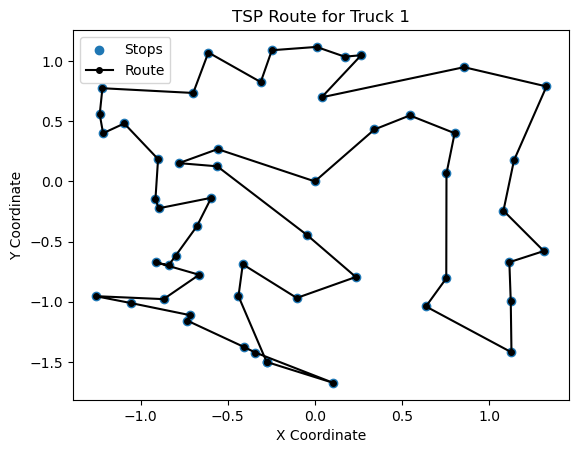

[128 181 137  97  62 123 163  56  70 100 241 329 208 361 372 339 351 441
 390 411 494 486 498  22   5  28 464  41  27  26  63  87 455   0 291 327
 379 262 318 286 275 337 281 205 229 211 270 159 187 128]



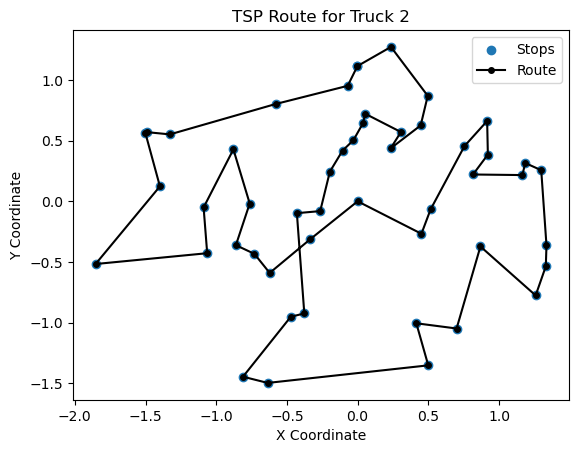

[ 99  12  54  24  16  93 136 129 189 160 109 176 107 149 143 162 179 222
 231 175 212 236   0 481 301 368 395 315 308 284 201 334 299 215 326 264
 335 333 386 366 377 431 477 488 403 448 378   2 454  42 497  46  20 125
  40  99]



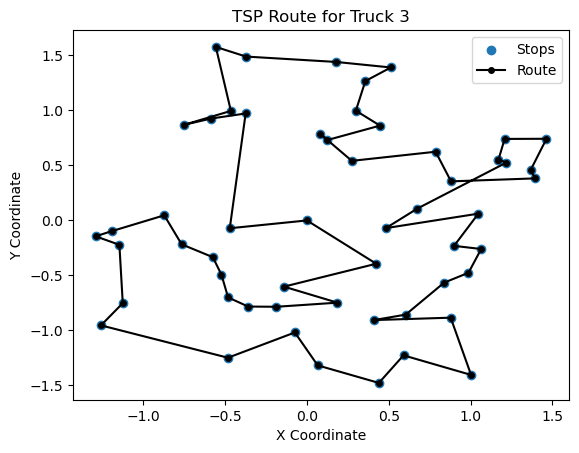

[398 245 230 206 221 207 185 118 146 194 199 238 131 105 121 122 101 126
 198 103  52  94  58  98  77  53  66  55  88 124 237   0 499 456  44 492
 415 406 436 355 434 394 419 367 371 372 422 346 303 302 261 269 271 277
 347 289 316 398]



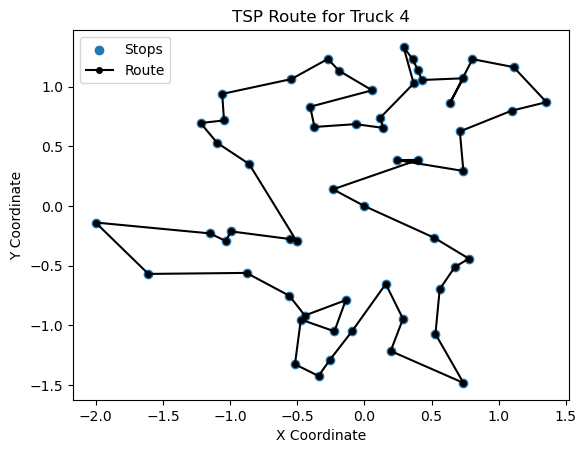

[447 430 425 483 437 457 482 479 461 490  11  45  33  72  30  73  90  84
  96  67  37  57  50 133 144 115 119 161 210 305 298 278 239 250 267 228
 251 223 195 244 177   0 369 362 445 363 354 402 325 385 370 396 359 450
 447]



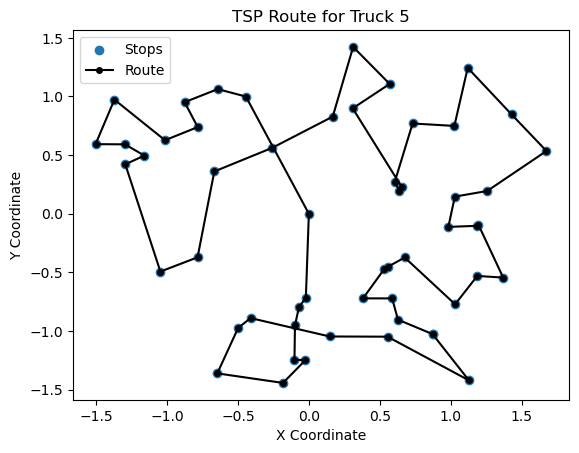

[285   0 476 336 344 201 208 224 157 178 153 247 232 180 182 110 111 106
  71  36  18 446 460 414 374 350 388 408 374 400 376 345 413 469  43  25
  69 113  78  74 285]



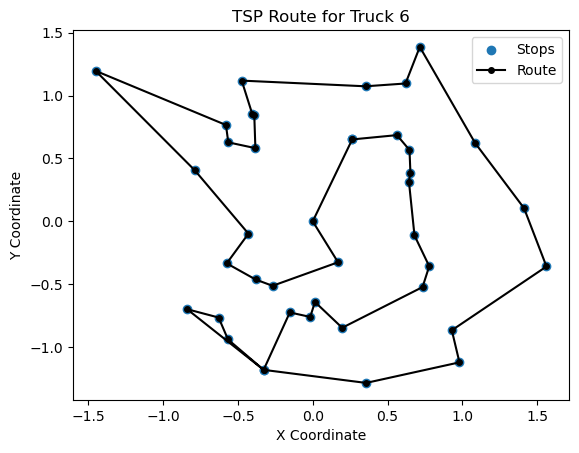

[  9 444 428 387 276 296 313 311 343 268 274 252 283 234 242 204 184 287
 307 320 384 309 399 418 353 487 412 383 439 432 443 493 470 420  47 463
 459 465 401  25  14  89  65  64  81  79 114  86  75 141 168 164 209 186
 155 197  68 116 216   0   9]



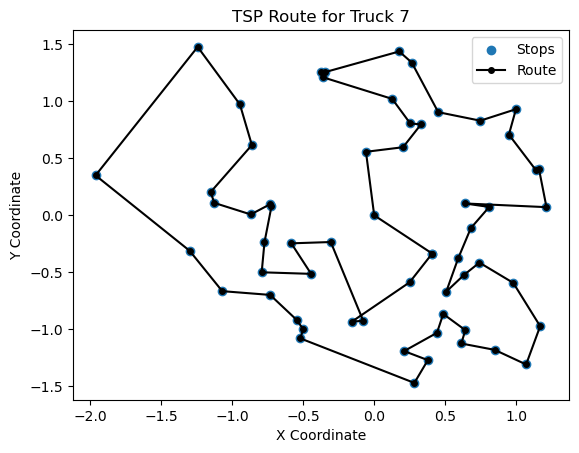

[243 218 328 295 264 317 260 294 322 290 319 256 332 341 397 410 442 427
 438 478 495 433  35 495  21  29  17  95  13  19  83  85  38 485   8   7
 424 405 489 373 364 435 297 265   0   1 474 138 102 112 132 142 169 150
 147 183 196 243]



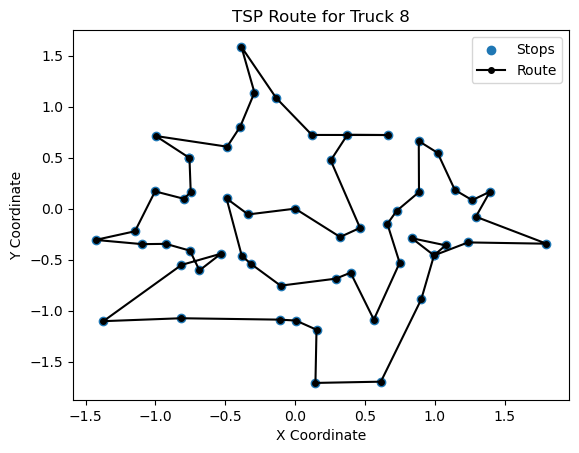

[259 340   0 338 375 426 409 467 496  23  49  82 127 140 192 220 152 202
 226 246 254 233 154 174 156  82  92   3  10 491  48 472 478 429 475 365
 407 357 393 324 279 272 263 273 259]



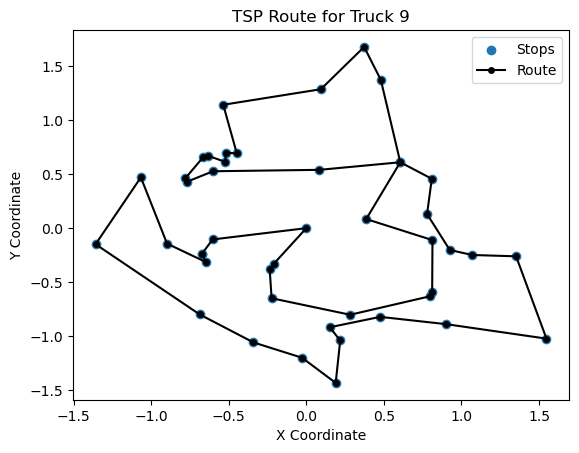

[ 32  15   6  35  39 451 484 471  34 473 404 440 391 421 352 381 349 462
   0 253 257 258 274 348 306 321 314 266 282 203 230 248 249 213 165 187
 108 104 100 190 225 191 219 255 193 171 173 172 151 166 158 127 130  60
 117  76 148 449  61  31 134  32]



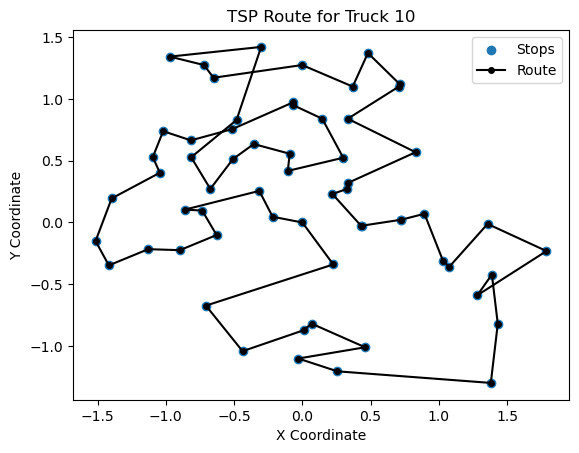

In [18]:
# plotting routes for 3-change annealing

num = 1
for path in best_path:
  path = np.append(path, path[0])
  print(path)
  print()
  x = []
  y = []
  for i in range(len(path)):
      row = path[i]
      stop = xy.iloc[row]
      x.append(stop[0])
      y.append(stop[1])

    # Scatter plot the points
  plt.scatter(x, y, cmap='rainbow', label='Stops')

    # Draw lines connecting the points in order
  plt.plot(x, y, linestyle='-', marker='o', markersize=4, c='k', label='Route')


  plt.title(f'TSP Route for Truck {num}')
  plt.xlabel('X Coordinate')
  plt.ylabel('Y Coordinate')
  plt.legend()
  plt.show()
  num += 1


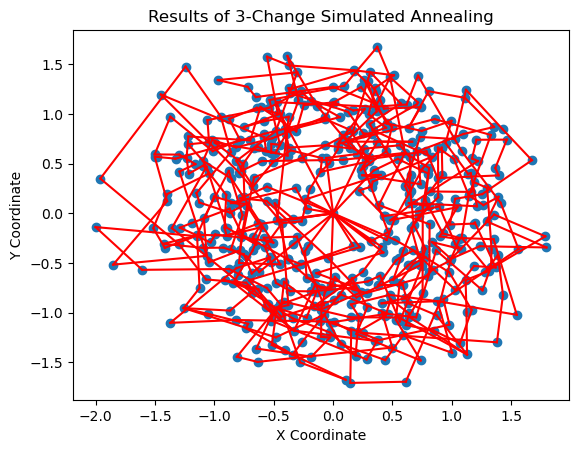

In [19]:
# Plot the routes for verification purposes
# 1) Is each route passing through the origin (0,0) / distribution center?
# 2) Is it a closed path?

draw_routes(xy, best_path, "Results of 3-Change Simulated Annealing")

## Part 2


In part 2, we introduce certain relevant costs and solve the TSP such that the total cost is minimized. We aim to determine how many trucks should be used with the following relevant costs:

For every mile travelled delivering packages it costs \$1 for gasoline, labor, truck depreciation
and so on. Additionally, every driver that works today gets an additional payment of $300, no
matter how many packages they deliver. Finally, any driver that works 10% more than the
average driver gets overtime pay of 1.5x for every hour over the average.

In [20]:
# Best model out of all truck number possibilities
top_distance = 100000000
top_path = np.array([])
top_cost = 100000000
no_trucks = 0

for i in range(10):
    # Cluster with k = i
    data = pd.read_csv('locations1.csv')
    X = data[['x', 'y']]

    num_clusters = i+1 # num clusters = num trucks

    # create and fit a K-Means model
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(X)
    data['cluster_label'] = kmeans.labels_

    if i > 0:
        # arrays for each truck
        trucks = [np.array([]) for j in range(i+1)]

        # Assigns the packages to the right truck
        for j in range(len(data)):
            cluster = data.iloc[j, 2]
            trucks[cluster] = np.append(trucks[cluster], [j])

        # Puts 0 at beginning of every truck route
        for j in range(len(trucks)):
            trucks[j] = np.append([0], trucks[j])
            trucks[j] = trucks[j].astype(int)

    else:
        trucks = np.array([range(len(data+1))])


    # Local bests for i number of drivers
    best_distance = measure_path(trucks,dist)
    best_path = np.copy(trucks)
    coin = 0.95

    for j in range(100000):
        test = np.copy(best_path)
        possible_methods = [transport(test), reversal(test)]
        method_choice = np.random.randint(0,2)
        method = possible_methods[method_choice]

        test[method[0]] = method[1]

        new_distance = measure_path(test,dist)

        if new_distance < best_distance:
            best_distance = new_distance
            best_path = test

        else:
            d = (new_distance**0.5) - (best_distance**0.5)
            prob = coin/(np.exp(d))
            if np.random.choice([0,1], p=[1-prob,prob]) == 1:
                best_path = test
                best_distance = new_distance

        coin *= 0.99

    best_distance = best_distance**0.5
    print(best_distance)
    print(i+1)
    #print(f"""No Trucks: {num_clusters}""")
    #print(f"""Best found distance: {best_distance}""")
    #print(best_path)

    if len(trucks) == 1:
      new_cost = best_distance + (i+1)*300

    else:
      avg_distance = best_distance / (i+1)
      additional_pay = 0
      for path in best_path:
        nx = len(path)
        path_dist = 0
        for i in range(nx-1):
            path_dist += dist[path[i],path[i+1]]
        path_dist += dist[path[nx-1],path[0]]
        if path_dist > avg_distance*1.1:
          additional_pay += 0.5*(path_dist - avg_distance)

      #print(f"""Additional pay: {additional_pay}""")
      new_cost = best_distance + additional_pay + (i+1)*300

    if new_cost < top_cost:
        top_cost = new_cost
        top_path = best_path
        top_distance = best_distance
        no_trucks = i+1


print(f"""Ideal number of trucks: {no_trucks}""")
print(f"""Ideal distance: {top_distance}""")
print(f"""Ideal path: {top_path}""")



94.74102901628437
1


/var/folders/wz/klh9z5615l97x31_xnrcm8280000gn/T/ipykernel_10670/3331613840.py:58: RuntimeWarning: overflow encountered in exp
  prob = coin/(np.exp(d))


64.92187140297544
2


/Users/rushilnakkana/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:804: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)
/var/folders/wz/klh9z5615l97x31_xnrcm8280000gn/T/ipykernel_10670/3331613840.py:58: RuntimeWarning: overflow encountered in exp
  prob = coin/(np.exp(d))


53.744684570259736
3


/Users/rushilnakkana/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:804: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)
/var/folders/wz/klh9z5615l97x31_xnrcm8280000gn/T/ipykernel_10670/3331613840.py:58: RuntimeWarning: overflow encountered in exp
  prob = coin/(np.exp(d))


47.213646213130296
4


/Users/rushilnakkana/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:804: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)
/var/folders/wz/klh9z5615l97x31_xnrcm8280000gn/T/ipykernel_10670/3331613840.py:58: RuntimeWarning: overflow encountered in exp
  prob = coin/(np.exp(d))


44.878008300538724
5


/Users/rushilnakkana/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:804: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)
/var/folders/wz/klh9z5615l97x31_xnrcm8280000gn/T/ipykernel_10670/3331613840.py:58: RuntimeWarning: overflow encountered in exp
  prob = coin/(np.exp(d))


42.51293661023528
6


/Users/rushilnakkana/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:804: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)
/var/folders/wz/klh9z5615l97x31_xnrcm8280000gn/T/ipykernel_10670/3331613840.py:58: RuntimeWarning: overflow encountered in exp
  prob = coin/(np.exp(d))


40.683231162148275
7


/Users/rushilnakkana/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:804: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)
/var/folders/wz/klh9z5615l97x31_xnrcm8280000gn/T/ipykernel_10670/3331613840.py:58: RuntimeWarning: overflow encountered in exp
  prob = coin/(np.exp(d))


40.346181837526906
8


/Users/rushilnakkana/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:804: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)
/var/folders/wz/klh9z5615l97x31_xnrcm8280000gn/T/ipykernel_10670/3331613840.py:58: RuntimeWarning: overflow encountered in exp
  prob = coin/(np.exp(d))


41.75339610590357
9


/Users/rushilnakkana/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:804: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)
/var/folders/wz/klh9z5615l97x31_xnrcm8280000gn/T/ipykernel_10670/3331613840.py:58: RuntimeWarning: overflow encountered in exp
  prob = coin/(np.exp(d))


40.373279102745194
10
Ideal number of trucks: 1
Ideal distance: 94.74102901628437
Ideal path: [[258 304 289 311 379 327 284 308 310 313   0 476 462  31 134  49 449  88
  124  91  62 138 145  82  69  50   4 485   3  15  14  32  33 437 457   8
  482 401  44 459 492 465 405 483 481   9 455 474  20  38  19  30  13 464
   81  64  99  90  53  59  77  54  71  83  28  46  72  11  17  95   5  16
   24  73  12  96  79  76 136  85  26 114  98  84  58  60  74 112  66  63
   51  92  93  27  40  45  39 471 490  34 420 460 470 473 450 486 468 466
  478 403 446 479 496 467 495   2 456   7 469 463  43 433 494  23  87  25
   89 125  41 480  65  36 451  29 498  21  22  48  18 491  42 452 497   6
   10  35 454  47 461 484 472 458 447 493 488 406 417 411 443 487 404 440
  357 397 366 394 410 396 442 377 407 353 427 423 392 367 360 351 339 341
  389 382 325 418 330 342 333 332 335 281 271 229 228 157 184 169 171 172
  209 186 185 220 182 150 142 162 179 173 207 151 164 118 222 175 188 244
  177 199 232 147 

In [21]:
print(f"""Cost: {top_cost}""")

Cost: 394.74102901628436


[258 304 289 311 379 327 284 308 310 313   0 476 462  31 134  49 449  88
 124  91  62 138 145  82  69  50   4 485   3  15  14  32  33 437 457   8
 482 401  44 459 492 465 405 483 481   9 455 474  20  38  19  30  13 464
  81  64  99  90  53  59  77  54  71  83  28  46  72  11  17  95   5  16
  24  73  12  96  79  76 136  85  26 114  98  84  58  60  74 112  66  63
  51  92  93  27  40  45  39 471 490  34 420 460 470 473 450 486 468 466
 478 403 446 479 496 467 495   2 456   7 469 463  43 433 494  23  87  25
  89 125  41 480  65  36 451  29 498  21  22  48  18 491  42 452 497   6
  10  35 454  47 461 484 472 458 447 493 488 406 417 411 443 487 404 440
 357 397 366 394 410 396 442 377 407 353 427 423 392 367 360 351 339 341
 389 382 325 418 330 342 333 332 335 281 271 229 228 157 184 169 171 172
 209 186 185 220 182 150 142 162 179 173 207 151 164 118 222 175 188 244
 177 199 232 147 180 212 167 165 128 120 146 166 155 108 119 163 194 139
 135 126 122 110 158 198 107 101 181 115 141 192 16

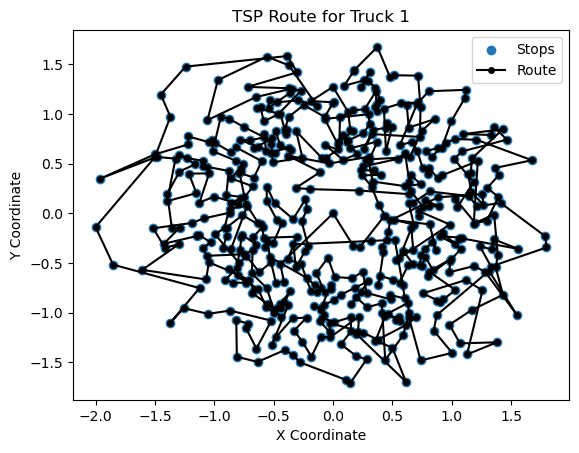

In [22]:
# plotting routes for cluster + 2-change annealing

num = 1
for path in top_path:
  path = np.append(path, path[0])
  print(path)
  print()
  x = []
  y = []
  for i in range(len(path)):
      row = path[i]
      stop = xy.iloc[row]
      x.append(stop[0])
      y.append(stop[1])

    # Scatter plot the points
  plt.scatter(x, y, cmap='rainbow', label='Stops')

    # Draw lines connecting the points in order
  plt.plot(x, y, linestyle='-', marker='o', markersize=4, c='k', label='Route')


  plt.title(f'TSP Route for Truck {num}')
  plt.xlabel('X Coordinate')
  plt.ylabel('Y Coordinate')
  plt.legend()
  plt.show()
  num += 1

In [23]:
#Best model out of all truck number possibilities
top_distance = 100000000
top_path = np.array([])
top_cost = 100000000
no_trucks = 0

for i in range(10):
    # Cluster with k = i
    data = pd.read_csv('locations1.csv')
    X = data[['x', 'y']]

    num_clusters = i+1 # num clusters = num trucks

    # create and fit a K-Means model
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(X)
    data['cluster_label'] = kmeans.labels_

    if i > 0:
        # arrays for each truck
        trucks = [np.array([]) for j in range(i+1)]

        # Need new datafram each time, with i clusters
        for j in range(1, len(data)):
            cluster = data.iloc[j, 2]
            trucks[cluster] = np.append(trucks[cluster], [j])

        # Puts 0 at beginning of every truck route
        for j in range(len(trucks)):
            trucks[j] = np.append([0], trucks[j])
            trucks[j] = trucks[j].astype(int)

    else:
        trucks = np.array([range(len(data))])


    # Local bests for i number of drivers
    coin = 0.95

    for j in range(100000):
        test = np.copy(trucks)
        possible_methods = [transport(test), reversal(test)]
        method_choice = np.random.randint(0,2)
        method = possible_methods[method_choice]

        test[method[0]] = method[1]

        new_distance = measure_path(test,dist)

        new_distance = new_distance**0.5

        if len(trucks) == 1:
            new_cost = new_distance + (i+1)*300

        else:
            avg_distance = new_distance / (i+1)
            additional_pay = 0
            for path in test:
              nx = len(path)
              path_dist = 0
            for i in range(nx-1):
              path_dist += dist[path[i],path[i+1]]
            path_dist += dist[path[nx-1],path[0]]
            if path_dist > avg_distance*1.1:
              additional_pay += 0.5*(path_dist - avg_distance)

            #print(f"""Additional pay: {additional_pay}""")
            new_cost = new_distance + additional_pay + (i+1)*300

        if new_cost < top_cost:
            top_cost = new_cost
            top_path = test
            top_distance = new_distance
            no_trucks = i+1



print(f"""Ideal number of trucks: {no_trucks}""")
print(f"""Ideal cost: {top_cost}""")
print(f"""Ideal path: {top_path}""")



/Users/rushilnakkana/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:804: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)
/Users/rushilnakkana/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:804: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)
/Users/rushilnakkana/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:804: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequenc

Ideal number of trucks: 1
Ideal cost: 616.1350969495408
Ideal path: [[420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
  474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491
  492 493 494 495 496 497 498 499   0   1   2   3   4   5   6   7   8   9
   10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27
   28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
   46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
   64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
   82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
  100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
  118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
  136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
  154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
  172 173 174 175 176 177 178 179 180 181 18

## Part 3

Tomorrow there is a new set of packages that need to be delivered to a new set of locations. We want to have some sort of consistency in the
neighborhoods/routes that each truck travels to, so we're thinking about putting packages that need to be delivered close to yesterday on the same truck as yesterday, and then solving the TSP for each truck.

In [24]:
# The decision we need to make is whether to enforce consistency between the routes generated
# based on the set of packages from locations1.csv and locations2.csv
# or to generate routes from scratch based on locations2.csv

# Assuming that we pick the Cluster + 2-Change Annealing method:
# Which method has the lower total cost? Consistent routes or generating routes from scratch?

# First, we load the new data.
data1 = pd.read_csv('locations1.csv')
data2 = pd.read_csv('locations2.csv')
data2.head()

,x,y
0,1.151486,-0.234319
1,1.365888,-0.150387
2,0.299276,-0.050275
3,1.088646,0.046591
4,0.945893,-0.260619


In [25]:
# Adds distribution center to dataframe
origin = pd.DataFrame({'x':0, 'y':0},index =[0])
data2 = pd.concat([origin, data2]).reset_index(drop = True)

# generate the distance matrix
nx = data2.shape[0]
dist2 = np.zeros((nx,nx))
for i in range(nx):
    for j in range(nx):
        if i == j:
            dist2[i,j] = 10000
        else:
            dist2[i,j] = np.sqrt((data2['x'][i]-data2['x'][j])**2 + (data2['y'][i]-data2['y'][j])**2)

dist2.shape

(501, 501)

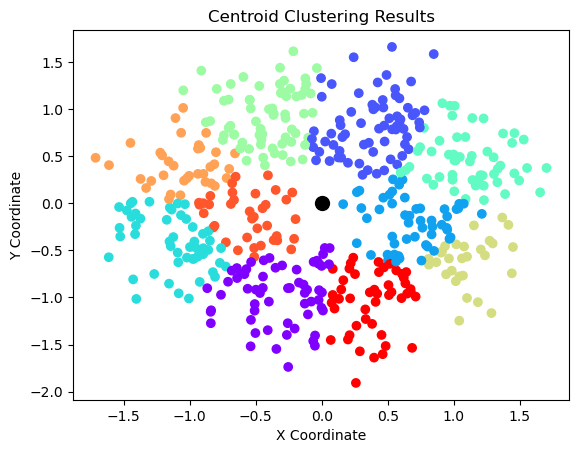

In [26]:
#@title Consistent Routes By Clustering
# Here, we are using the centroid method to generate clusters similar to location1 clusters

X1 = data1[['x', 'y']]
X2 = data2[['x', 'y']]
num_clusters = 10 # num clusters = num trucks

# location1 clusters
kmeans = KMeans(n_clusters=num_clusters)
y_predict = kmeans.fit_predict(X1)

# find centroids of locations1 clusters
clf = NearestCentroid()
clf.fit(X1, y_predict)
centroids = clf.centroids_

# create and fit a K-Means model to cluster locations2 data based on centroids from locations1 data
kmeans = KMeans(n_clusters=num_clusters, init=centroids, max_iter=1, n_init=1)
kmeans.fit(X2)
data2['cluster_label'] = kmeans.labels_
plt.scatter(data2['x'], data2['y'], c=data2['cluster_label'], cmap='rainbow')
# plt.scatter(data1['x'], data1['y'], c=data1['cluster_label'], cmap='rainbow')
plt.title('Centroid Clustering Results')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.scatter(0, 0, c='black', marker='o', s=100)  # Adjust the size (s) as needed
plt.show()

In [27]:
# Perform 2-Change Annealing on Centroid Clusters

trucks = [np.array([]) for i in range(10)]

for i in range(len(data2)): # Go through entire data set
  cluster = data2.iloc[i, 2] # Locate the cluster number it is (1-10)
  trucks[cluster] = np.append(trucks[cluster], [i]) # appends the package number in the correct truck

# adds distribution center to every truck route
for i in range(len(trucks)):
  trucks[i] = np.append([0], trucks[i])
  trucks[i] = trucks[i].astype(int)

# baseline truck route distance
best_distance = measure_path(trucks,dist2)
print(f"""Starting distance: {best_distance**0.5}""")
# the original path from our truck arrays
best_path = np.copy(trucks)
coin = 0.95

for i in range(100000):
    test = np.copy(best_path) # path to change
    possible_methods = [transport(test), reversal(test)] # stores the two possible changes
    # 50/50 shot of choosing either
    method_choice = np.random.randint(0,2)
    method = possible_methods[method_choice]

    test[method[0]] = method[1]

    new_distance = measure_path(test,dist2)

    if new_distance < best_distance:
        best_distance = new_distance
        best_path = test

    else:
        d = (new_distance**0.5) - (best_distance**0.5)
        prob = coin/(np.exp(d))
        if np.random.choice([0,1], p=[1-prob,prob]) == 1:
            best_path = test
            best_distance = new_distance

    coin *= 0.99

best_distance = best_distance**0.5
avg_distance = best_distance / len(trucks)
additional_pay = 0
for path in best_path:
  nx = len(path)
  path_dist = 0
  for i in range(nx-1):
    path_dist += dist2[path[i],path[i+1]]
  path_dist += dist2[path[nx-1],path[0]]
  if path_dist > avg_distance*1.1:
    additional_pay += 0.5*(path_dist - avg_distance)

total_cost = best_distance + additional_pay + (len(trucks))*300

print(f"""Ending distance: {best_distance}""")
print(f"""Ideal paths: {best_path}""")
print(f"""Total Cost: {total_cost}""")


Starting distance: 10015.905653679965


/Users/rushilnakkana/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:804: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)
/var/folders/wz/klh9z5615l97x31_xnrcm8280000gn/T/ipykernel_10670/2825111898.py:38: RuntimeWarning: overflow encountered in exp
  prob = coin/(np.exp(d))


Ending distance: 21.91090993451706
Ideal paths: [array([353, 429, 349, 359, 369, 388, 368, 303, 327, 318, 400, 378, 390,
        365, 379, 356, 373, 382, 358, 450, 404, 427, 398, 367, 362, 374,
        387, 320, 394, 340, 410, 337, 397, 355, 363, 352, 302, 381, 391,
        351, 361, 326, 331, 440, 430, 420, 417, 437, 436, 432, 445,   0,
        446, 402, 392, 389, 376, 371, 401, 425, 372, 395])
 array([ 60, 147,  79, 109,  64, 132, 122,  75, 112, 106,  52, 110, 149,
         77, 142,  73,  59, 131, 139, 134, 117,  87,   0, 214, 199, 156,
        238, 129, 119, 118, 150, 168, 128, 135, 160,  70, 104, 115, 145,
        136, 130, 101, 126, 121, 137, 144, 116, 171, 146, 185, 113,  54,
        228, 196, 127, 105, 120, 172, 123,  56,  74,  53,  47,  92,  68,
         58,  83, 103, 124])
 array([482, 439, 424, 485, 393, 399,  22, 464, 473, 435,  41,  35,  14,
         26,  13,  96, 478,   3, 452,   0,  89,   8,  25,  36, 496,  81,
         42,  57,   7,  30,  20, 500,  33, 492,  16,   6,  76

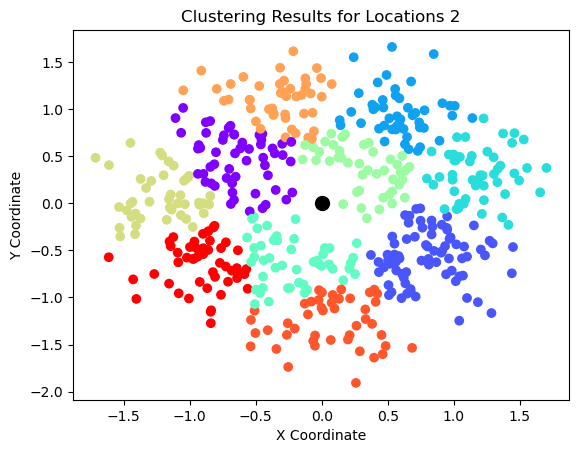

In [28]:
#@title Generating Routes from Scratch
# Generate clusters from scratch
data2 = pd.read_csv('locations2.csv')
data2.head()
X2 = data2[['x', 'y']]
num_clusters = 10 # num clusters = num trucks

# location1 clusters
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X2)
data2['cluster_label'] = kmeans.labels_
plt.scatter(data2['x'], data2['y'], c=data2['cluster_label'], cmap='rainbow')
plt.title('Clustering Results for Locations 2')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.scatter(0, 0, c='black', marker='o', s=100)  # Adjust the size (s) as needed
plt.show()

In [29]:
# Perform 2-Change Annealing on New Clusters

trucks = [np.array([]) for i in range(10)]

for i in range(len(data2)): # Go through entire data set
  cluster = data2.iloc[i, 2] # Locate the cluster number it is (1-10)
  trucks[cluster] = np.append(trucks[cluster], [i]) # appends the package number in the correct truck

# adds distribution center to every truck route
for i in range(len(trucks)):
  trucks[i] = np.append([0], trucks[i])
  trucks[i] = trucks[i].astype(int)

# baseline truck route distance
best_distance = measure_path(trucks,dist2)
print(f"""Starting distance: {best_distance**0.5}""")
# the original path from our truck arrays
best_path = np.copy(trucks)
coin = 0.95

for i in range(100000):
    test = np.copy(best_path) # path to change
    possible_methods = [transport(test), reversal(test)] # stores the two possible changes
    # 50/50 shot of choosing either
    method_choice = np.random.randint(0,2)
    method = possible_methods[method_choice]

    test[method[0]] = method[1]

    new_distance = measure_path(test,dist2)

    if new_distance < best_distance:
        best_distance = new_distance
        best_path = test

    else:
        d = (new_distance**0.5) - (best_distance**0.5)
        prob = coin/(np.exp(d))
        if np.random.choice([0,1], p=[1-prob,prob]) == 1:
            best_path = test
            best_distance = new_distance

    coin *= 0.99

best_distance = best_distance**0.5
avg_distance = best_distance / len(trucks)
additional_pay = 0
for path in best_path:
  nx = len(path)
  path_dist = 0
  for i in range(nx-1):
    path_dist += dist2[path[i],path[i+1]]
  path_dist += dist2[path[nx-1],path[0]]
  if path_dist > avg_distance*1.1:
    additional_pay += 0.5*(path_dist - avg_distance)

total_cost = best_distance + additional_pay + (len(trucks))*300

print(f"""Ending distance: {best_distance}""")
print(f"""Ideal paths: {best_path}""")
print(f"""Total Cost: {total_cost}""")


Starting distance: 10045.922092063864


/Users/rushilnakkana/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:804: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)
/var/folders/wz/klh9z5615l97x31_xnrcm8280000gn/T/ipykernel_10670/952014253.py:38: RuntimeWarning: overflow encountered in exp
  prob = coin/(np.exp(d))


Ending distance: 37.37632304645388
Ideal paths: [array([207, 223, 226, 236, 211, 247, 154, 224, 222, 240, 204, 221, 235,
        272, 231, 281, 203, 266, 206, 243, 233, 220, 278, 210, 271, 297,
        280, 284, 292, 261, 305, 303, 276, 256, 217, 262, 225, 346,   0,
        106, 228, 196, 153, 239, 241, 202, 158, 246, 186, 234, 200, 189,
        173, 175, 157, 230])
 array([ 28,  19,  39,  31,  21,  37,   4, 453,  34,  40, 463, 456, 454,
        455,  29, 421, 462, 498, 443, 438, 412, 405, 441, 450, 363,   0,
        432, 420, 417, 466, 392, 434, 493, 488, 467, 484, 474, 476, 413,
        422, 406, 470, 459, 460, 481, 475, 423, 458, 497, 499, 482, 457,
        480, 485, 407, 479, 464,  22, 473, 490, 469, 472, 471, 468,  32,
        489, 461,  26, 478,   0,  13,  25, 496,  47,  62,  45])
 array([120, 123, 105, 129, 141, 159, 184, 114, 118, 146, 115, 125, 135,
        136, 121, 145, 144, 110, 142, 103,  97, 111, 109,  79,  60, 108,
        143, 148,  69,  51, 102,  82, 100,  78,  76,  63